# OSale Data Exploration

Data exploration is the first step we have to do after we finished the creation of the flat-file dataset.
The things we have to check are:
 
1. Identify data types and data distributions
2. Identify quantity and type of missing values
3. Identify outliers (univariate and multivariate)
4. Identify data patterns (using cluster analysis / PCA)



In [1]:
if(!require(DBI)){install.packages("DBI"); require(DBI)}
if(!require(RSQLite)){install.packages("RSQLite"); require(RSQLite)}
require(dplyr)

Loading required package: DBI
Loading required package: RSQLite
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
ROOT_PATH = "/home/tomas/Documents/Technion/class_project/"
DATA_PATH = "/home/tomas/Documents/Technion/class_project/data/raw/"
DB_FILE = paste0(DATA_PATH,"/olist.db") 

In [3]:
##############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################
            
#### Read function to import data from the SQL to a pandas dataframe.
readSQL <- function(query, db=DB_FILE) {
    require(DBI)
    require(RSQLite)
    con <- dbConnect(SQLite(), DB_FILE)
    df <- dbGetQuery(con, query)
    return(df)
}


In [4]:
sellers = readSQL("SELECT * FROM sellers_dataset")

In [5]:
dim(sellers)

[1] 901  82

In [6]:
head(sellers)

seller_id,outcome,seller_zip_code_prefix,seller_city,seller_state,categories_count,products_count,cat_1,cat_2,cat_3,⋯,cat_66,cat_67,cat_68,cat_69,cat_70,cat_71,cat_72,cat_73,cat_74,competitors_count
0015a82c2db000af6aaaf3ae2ecb0532,0,9080,santo andre,SP,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,56
003554e2dce176b5555353e4f3555ac8,0,74565,goiania,GO,1,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,204
00ab3eff1b5192e5f1a63bcecfee11c8,0,4164,sao paulo,SP,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,106
010543a62bd80aa422851e79a3bc7540,0,1212,sao paulo,SP,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,124
011b0eaba87386a2ae96a7d32bb531d1,0,17580,pompeia,SP,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,17
01bcc9d254a0143f0ce9791b960b2a47,1,76400,uruacu,GO,1,3,0,0,0,⋯,0,0,0,0,0,0,0,0,0,183


In [7]:
excludeUniqueValue <- function(data) {
    nm <- names(data)
    res <- NULL
    for(n in nm) {
        if(length(unique(data[[n]]))==1) {
            data[[n]] <- NULL
            res <- c(res, n)
            #print(n)
        }
    }
    if(length(res) > 0) {
        message("The following variables had only one unique values and were removed")
        message(res)
    }
    return(data)
}

In [8]:
sellers <- excludeUniqueValue(sellers)
head(sellers)

The following variables had only one unique values and were removed
cat_7cat_17cat_19cat_25cat_43cat_48cat_62cat_67cat_69


seller_id,outcome,seller_zip_code_prefix,seller_city,seller_state,categories_count,products_count,cat_1,cat_2,cat_3,⋯,cat_64,cat_65,cat_66,cat_68,cat_70,cat_71,cat_72,cat_73,cat_74,competitors_count
0015a82c2db000af6aaaf3ae2ecb0532,0,9080,santo andre,SP,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,56
003554e2dce176b5555353e4f3555ac8,0,74565,goiania,GO,1,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,204
00ab3eff1b5192e5f1a63bcecfee11c8,0,4164,sao paulo,SP,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,106
010543a62bd80aa422851e79a3bc7540,0,1212,sao paulo,SP,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,124
011b0eaba87386a2ae96a7d32bb531d1,0,17580,pompeia,SP,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,17
01bcc9d254a0143f0ce9791b960b2a47,1,76400,uruacu,GO,1,3,0,0,0,⋯,0,0,0,0,0,0,0,0,0,183


In [11]:
getMissingness <- function(data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [12]:
getMissingness(sellers)

[[1]]
[1] var      na.count rate    
<0 rows> (or 0-length row.names)

[[2]]
[1] "This dataset has 901 (100%) complete rows. Original data has 901 rows."



var,na.count,rate


In [14]:
summary(sellers)

  seller_id            outcome       seller_zip_code_prefix seller_city       
 Length:901         Min.   :0.0000   Min.   : 1026          Length:901        
 Class :character   1st Qu.:0.0000   1st Qu.: 6787          Class :character  
 Mode  :character   Median :0.0000   Median :15170          Mode  :character  
                    Mean   :0.3685   Mean   :33129                            
                    3rd Qu.:1.0000   3rd Qu.:74210                            
                    Max.   :1.0000   Max.   :99700                            
 seller_state       categories_count products_count       cat_1       
 Length:901         Min.   : 1.00    Min.   : 1.000   Min.   :0.0000  
 Class :character   1st Qu.: 1.00    1st Qu.: 1.000   1st Qu.:0.0000  
 Mode  :character   Median : 1.00    Median : 2.000   Median :0.0000  
                    Mean   : 1.58    Mean   : 3.788   Mean   :0.1743  
                    3rd Qu.: 2.00    3rd Qu.: 4.000   3rd Qu.:0.0000  
                    M

In [16]:
## variables to exclude
exclude <- c("seller_id","seller_zip_code_prefix","seller_city","seller_state")
## numeric variables
nv <- c("categories_count","products_count","competitors_count")
## categorical variables
cv <- setdiff(names(sellers),c(exclude,nv))

In [18]:
exclude
nv
cv

[1] "seller_id"              "seller_zip_code_prefix" "seller_city"           
[4] "seller_state"

[1] "categories_count"  "products_count"    "competitors_count"

[1] "outcome" "cat_1"   "cat_2"   "cat_3"   "cat_4"   "cat_5"   "cat_6"  
 [8] "cat_8"   "cat_9"   "cat_10"  "cat_11"  "cat_12"  "cat_13"  "cat_14" 
[15] "cat_15"  "cat_16"  "cat_18"  "cat_20"  "cat_21"  "cat_22"  "cat_23" 
[22] "cat_24"  "cat_26"  "cat_27"  "cat_28"  "cat_29"  "cat_30"  "cat_31" 
[29] "cat_32"  "cat_33"  "cat_34"  "cat_35"  "cat_36"  "cat_37"  "cat_38" 
[36] "cat_39"  "cat_40"  "cat_41"  "cat_42"  "cat_44"  "cat_45"  "cat_46" 
[43] "cat_47"  "cat_49"  "cat_50"  "cat_51"  "cat_52"  "cat_53"  "cat_54" 
[50] "cat_55"  "cat_56"  "cat_57"  "cat_58"  "cat_59"  "cat_60"  "cat_61" 
[57] "cat_63"  "cat_64"  "cat_65"  "cat_66"  "cat_68"  "cat_70"  "cat_71" 
[64] "cat_72"  "cat_73"  "cat_74"

## Numeric Variables

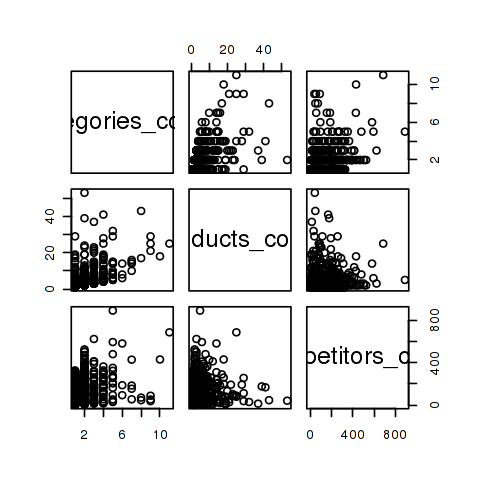

In [24]:
options(repr.plot.width = 4, repr.plot.height = 4)
pairs(sellers[,nv])

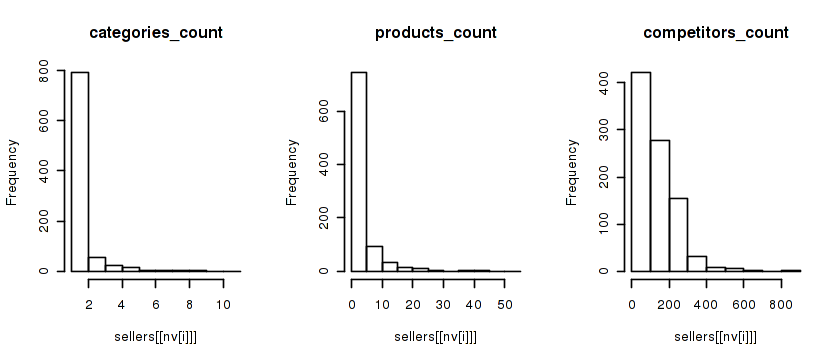

In [76]:
options(repr.plot.width = 7, repr.plot.height = 3)
par(mfrow=c(1,3))
i <- 1
for(y in 1:length(nv)) {
    hist(sellers[[nv[i]]],main=nv[i])
    i <- i + 1
}


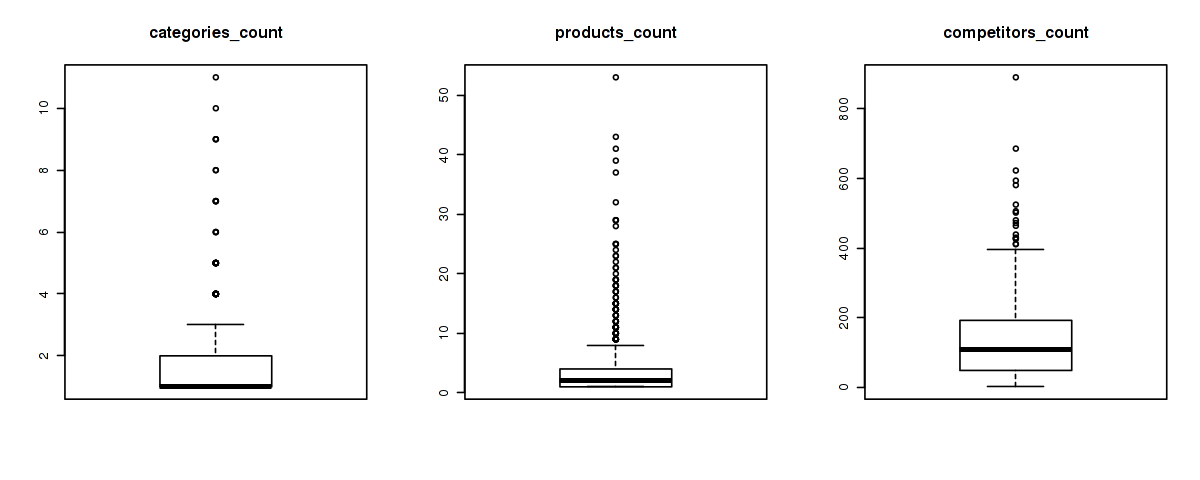

In [61]:
options(repr.plot.width = 10, repr.plot.height = 4)
par(mfrow=c(1,3))
i <- 1
for(y in 1:length(nv)) {
    boxplot(sellers[[nv[i]]],main=nv[i])
    i <- i + 1
}


### Outlier analysis

[1]  9  5  6  5  4  4  5  4  4  4  6  7  6  8  4  4  4  5  4  4  4  4  4  5  5
[26]  4  7 10  4  5  5  4  5  4  5  4  4  5  9  5  8 11  4  4  7  4  9  4  5  5
[51]  5  4  4  7

[1] 54

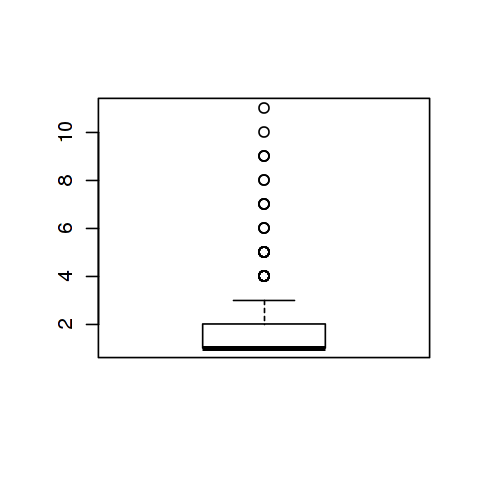

In [66]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt1 <- boxplot(sellers$categories_count)
plt1$out
length(plt1$out)


[1] 21  9 14 10 18  9 14 15 15  9 11 11 25 12 13 15 14 12 10 13 11  9 17 11 11
[26] 29 28 13  9 10  9  9 24 12 17  9 19  9  9 23 14 18 11 15 41 16 39 19 19  9
[51] 12 53 14 10 23 18 19 32 10 15 21 10 22  9 11  9 15 15 11 25 37 43 25 14 16
[76] 13 10 29 29 10 12 20 14 18 11 17 15

[1] 87

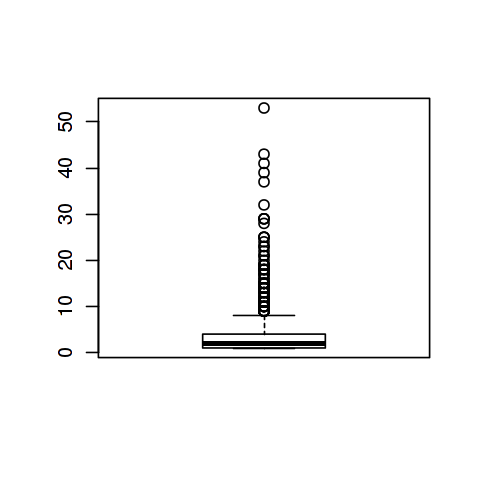

In [67]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt2 <- boxplot(sellers$products_count)
plt2$out
length(plt2$out)


[1] 502 426 594 506 525 412 581 428 472 623 430 891 686 464 480 411 439

[1] 17

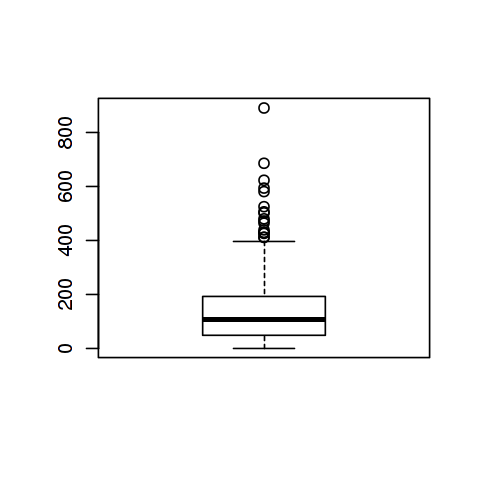

In [71]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt3 <- boxplot(sellers$competitors_count)
plt3$out
length(plt3$out)


### Multivariable Outliers

   Mode   FALSE    TRUE 
logical     853      48 

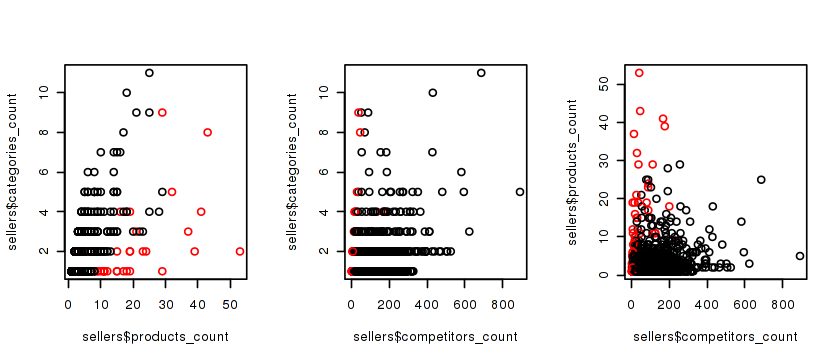

In [84]:
library(mvoutlier)
## multivariate outliers

mout <- mvoutlier.CoDa(sellers[,nv])
summary(mout$outliers)
par(mfrow=c(1,3))
plot(sellers$categories_count ~ sellers$products_count, col=mout$outliers+1)
plot(sellers$categories_count ~ sellers$competitors_count, col=mout$outliers+1)
plot(sellers$products_count ~ sellers$competitors_count, col=mout$outliers+1)


### Most common causes of outliers

* Data entry errors (human errors)
* Measurement error (instrument errors)
* Experimental errors (data extraction planning/executing errors)
* Intentional (made to test detection methods)
* Processing errors (data manipulation or by imputation)
* Sampling errors (data from a different distribution/source)
* Natural (not an error, novelty in data)
 

## Categorical Variables

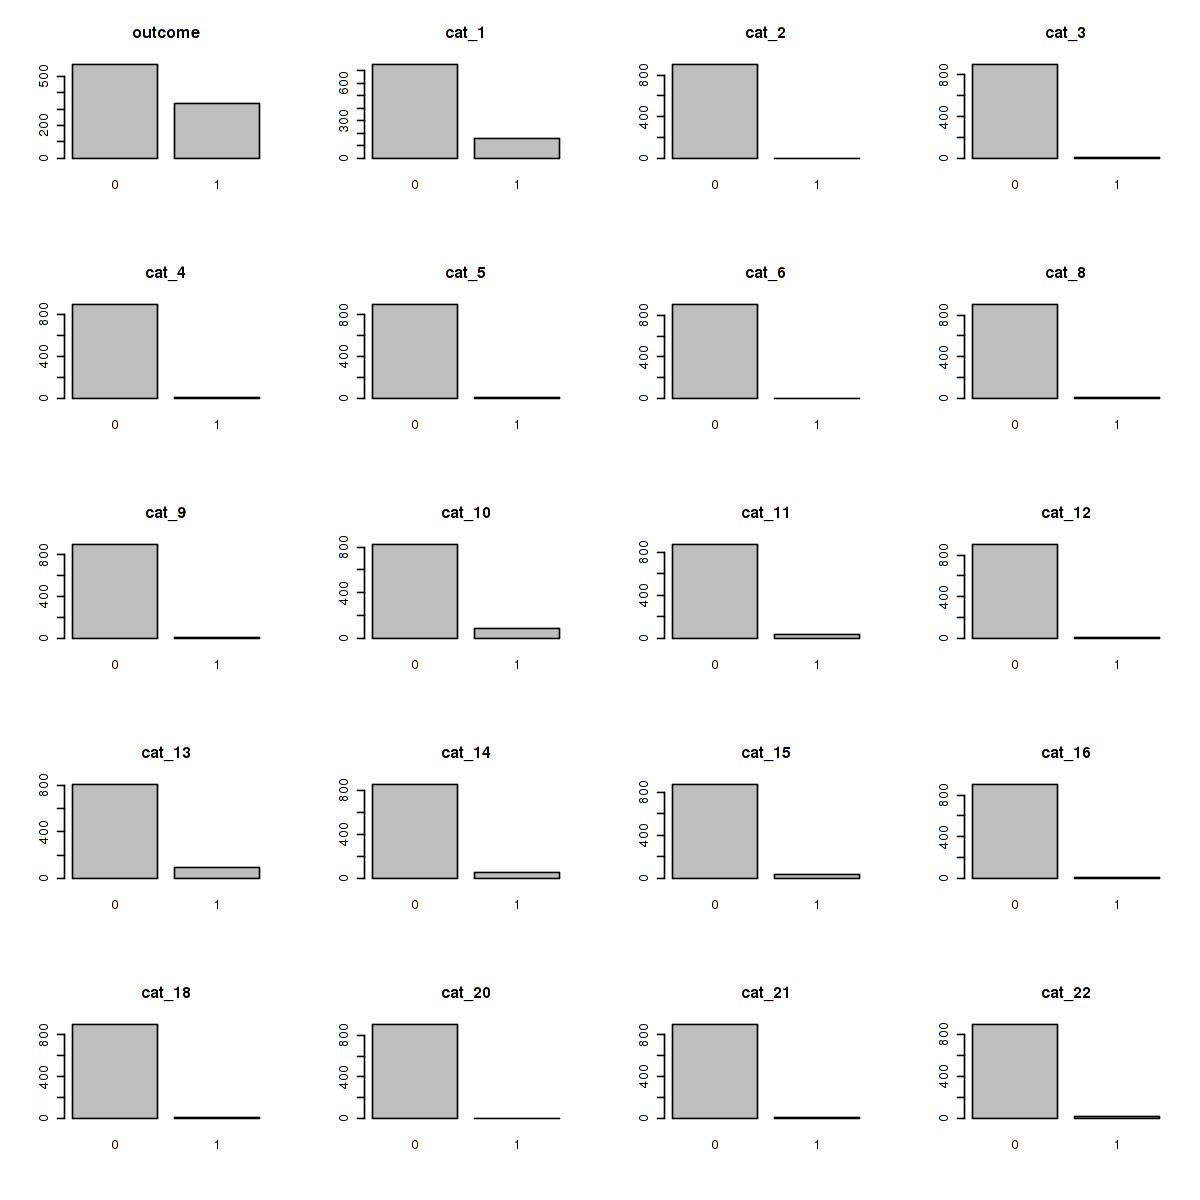

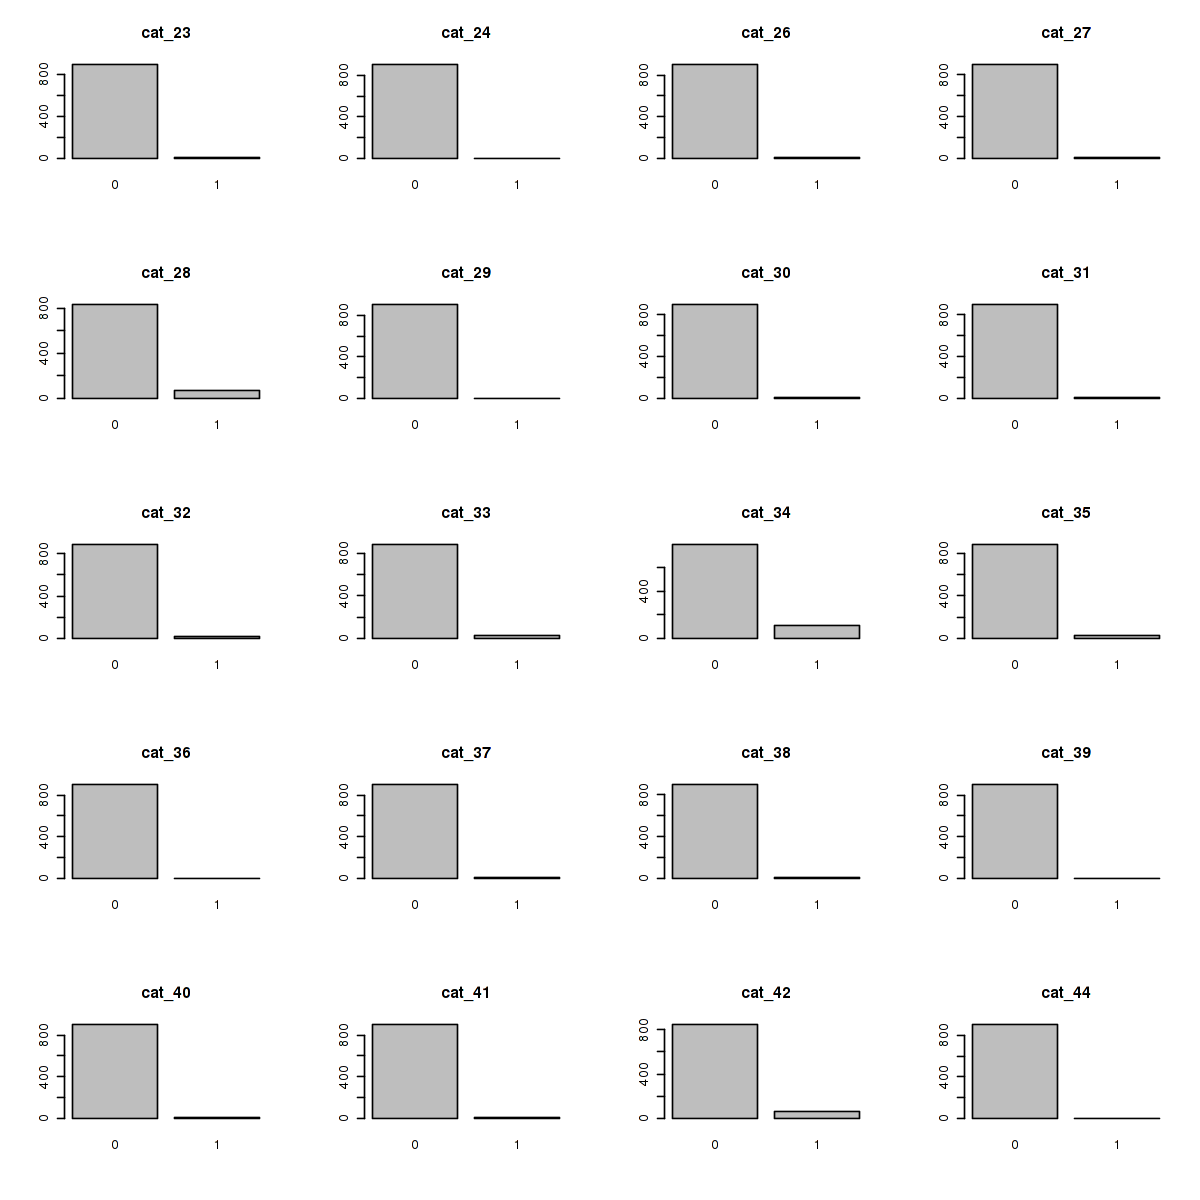

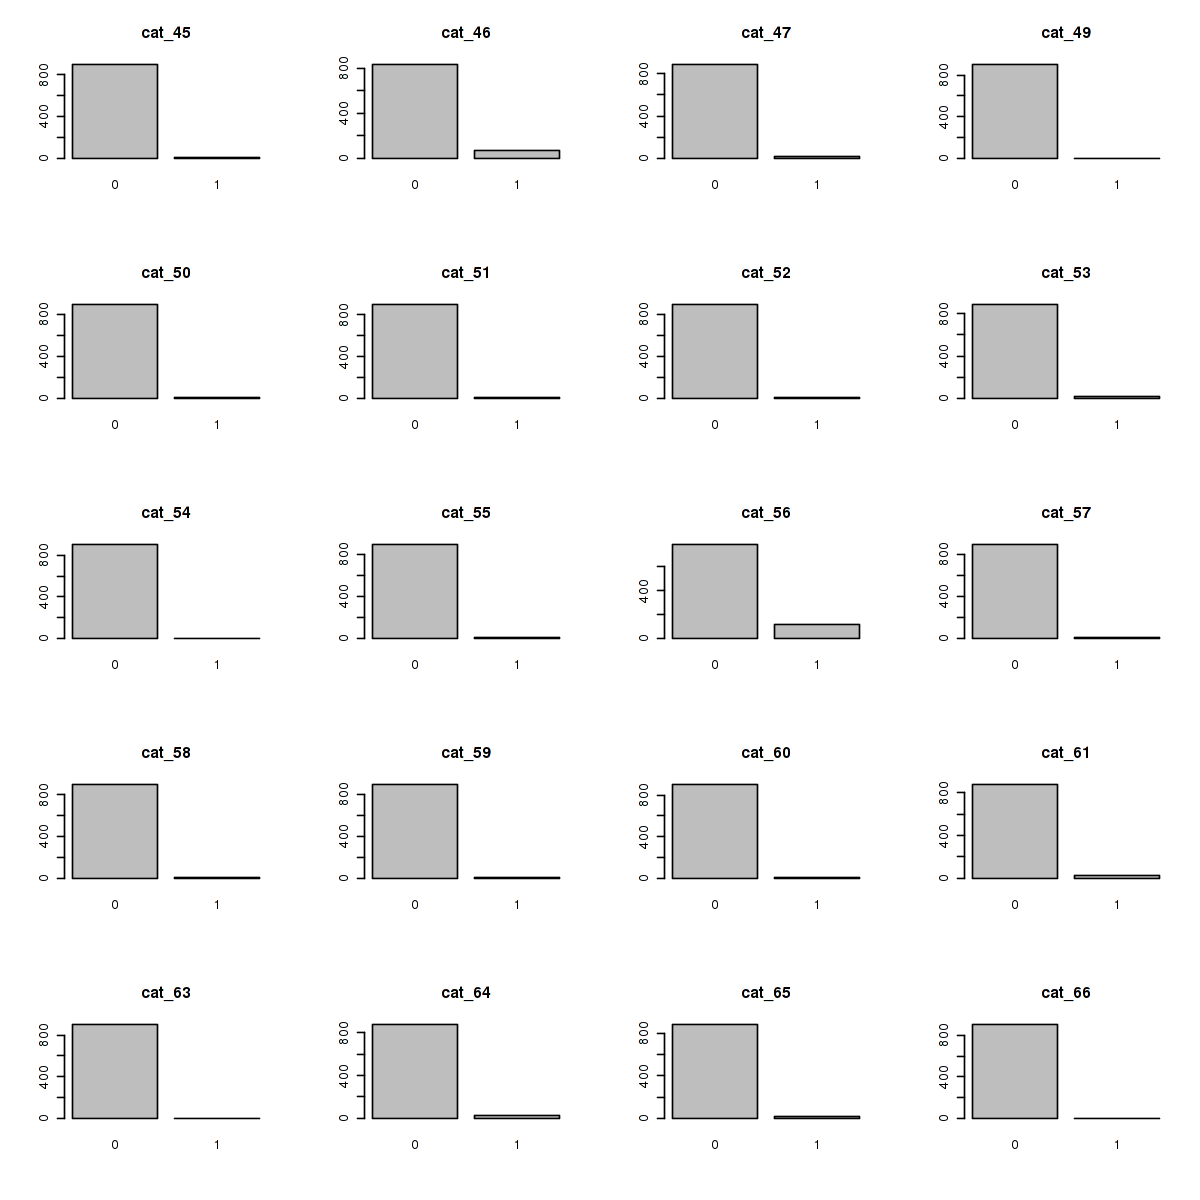

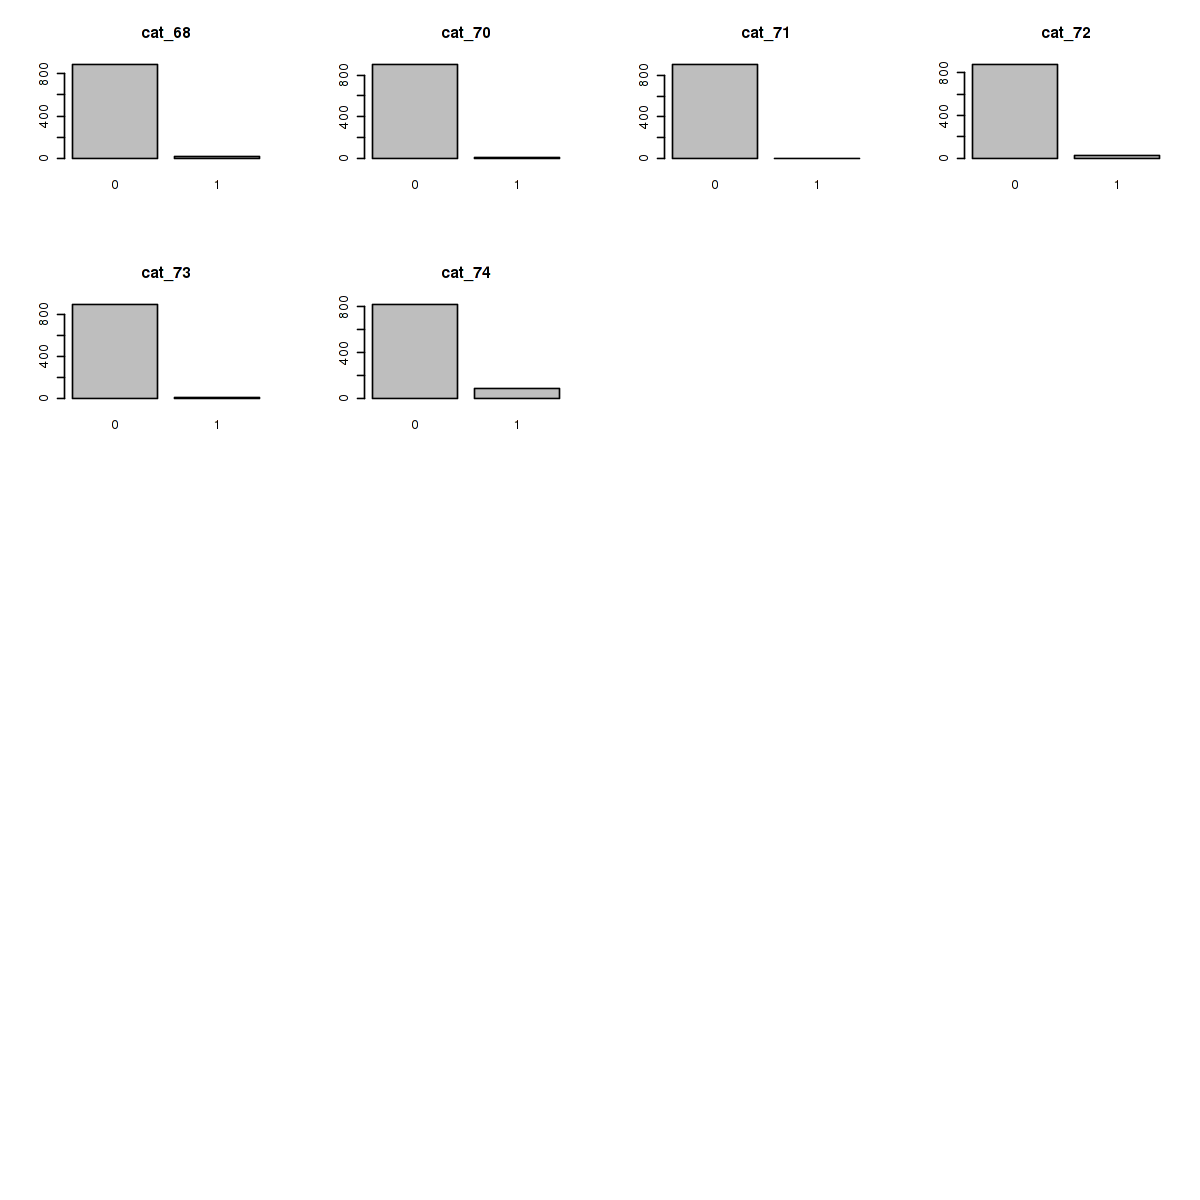

In [86]:
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow=c(5,4))
i <- 1
for(y in 1:length(cv)) {
    barplot(table(sellers[[cv[i]]]),main=cv[i])
    i <- i + 1
}


## Serching for patterns on the data

[1] 0.997 0.003 0.000 0.000 0.000

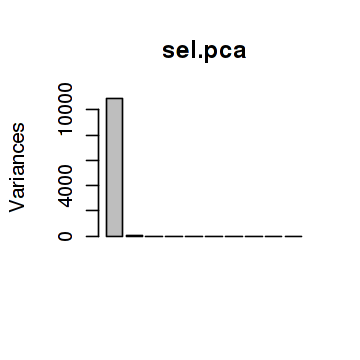

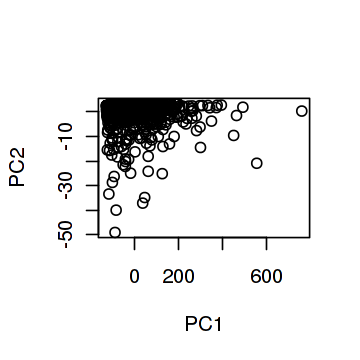

In [98]:
options(repr.plot.width = 3, repr.plot.height = 3)

sel.pca <- prcomp(sellers[c(nv,cv)])

round(sel.pca$sdev^2/sum(sel.pca$sdev^2),3)[1:5]

plot(sel.pca)
plot(sel.pca$x)


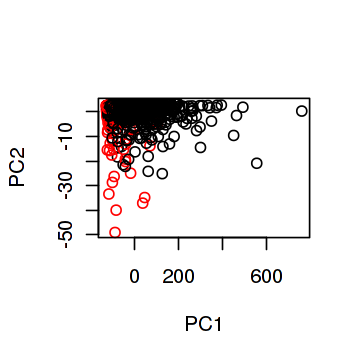

In [92]:
plot(sel.pca$x, col=mout$outliers+1)

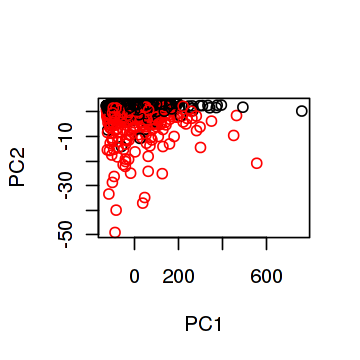

In [93]:
plot(sel.pca$x, col=sellers$outcome+1)